# MINI PROJET 1: Qui a peint ce tableau ?

In [1]:
# Utils
import os
import shutil
import time

# Maths - Stats
from sklearn.utils import shuffle
import numpy as np
import pandas as pd
import random as rd

# Data visualization
from matplotlib import pyplot as plt
import seaborn as sns

# Deep Learning Librairies
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

2024-10-17 14:26:39.176299: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-17 14:26:40.293154: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-17 14:26:40.593221: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-17 14:26:42.388591: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-17 14:27:00.238261: W tensorflow/comp

In [10]:
# tf.config.list_physical_devices()
[k.device_type for k in tf.config.list_physical_devices()]

['CPU', 'GPU']

In [ ]:
print(device_type)

## Preparation du jeu de données

In [13]:
# Vérifie si le dossier "data" existe, et le supprime s'il est présent.
if os.path.exists("data"):
    shutil.rmtree("data")  # Supprime le dossier et tout son contenu

# Définition du chemin vers le dossier contenant les images des auteurs.
path = "./images_hq/"

# Initialisation d'une liste pour stocker les labels (noms d'auteurs).
labels = []

# Si le dossier "data" n'existe pas, il est créé.
if not os.path.exists("data"):
    os.mkdir("data")  # Crée un nouveau dossier "data"

# Parcours du contenu du dossier `path` (dossier contenant les sous-dossiers d'auteurs).
for author_folder in os.listdir(path):
    # Pour chaque sous-dossier d'auteur, obtient le chemin complet.
    author_path = os.path.join(path, author_folder)
    
    # Parcours de chaque image dans le sous-dossier de l'auteur.
    for image_filename in os.listdir(author_path):
        # Initialisation d'une chaîne vide pour stocker le nom de l'auteur.
        author_name = ""
        
        # Séparation du nom de fichier selon les underscores ('_'), pour reconstruire le nom de l'auteur.
        # L'image est supposée être nommée avec le format "prénom_nom_something.jpg"
        # On extrait ici toutes les parties du nom avant le dernier underscore.
        for i in range(len(image_filename.split('_')) - 1):
            author_name += image_filename.split('_')[i] 
            # La ligne suivante (en commentaire) sert à tester ou déboguer si nécessaire
            # print(author_name, author_folder)
    
        # Copie le fichier d'image depuis son emplacement d'origine vers le dossier "data".
        src = os.path.join(author_path, image_filename)  # Chemin source
        dst = os.path.join("data/", image_filename)  # Chemin destination
        shutil.copyfile(src, dst)  # Copie le fichier d'origine vers la destination
        
        # Ajoute le nom de l'auteur à la liste des labels.
        labels.append(author_name)

# Liste tous les fichiers dans le dossier "data", qui sont les fichiers d'image copiés.
train_filename = os.listdir("data")

In [15]:

total_df = pd.DataFrame({
    'filename': train_filename,
    'category': labels
})

In [18]:
total_df.head()

filename       category
0    Albrecht_Dürer_1.jpg  AlbrechtDürer
1   Albrecht_Dürer_10.jpg  AlbrechtDürer
2  Albrecht_Dürer_100.jpg  AlbrechtDürer
3  Albrecht_Dürer_101.jpg  AlbrechtDürer
4  Albrecht_Dürer_102.jpg  AlbrechtDürer

## Visualisation des images

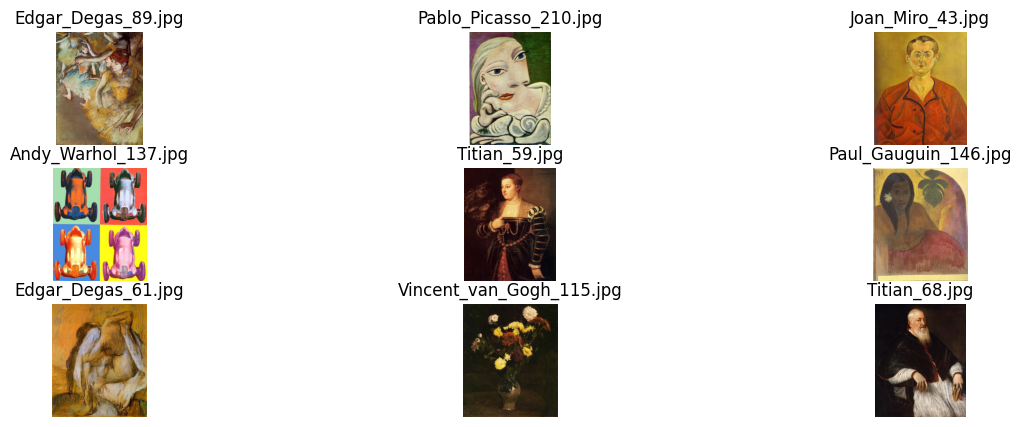

In [19]:
from tensorflow.keras.utils import load_img, img_to_array
fig,axe=plt.subplots(3,3,figsize=(15,5))

for i in range(3):
    for j in range(3):
        filename = rd.choice(total_df['filename'])
        img = load_img("data/" + filename)

          # Sélectionne une image appartenant à la classe k
        
        # Affiche l'image sur l'axe correspondant
        axe[i, j].imshow(img)  # Ajuster cmap selon vos images (ex: 'gray' pour images en niveaux de gris)
        axe[i, j].set_title(filename)  # Ajoute un titre pour chaque sous-graphe
        axe[i, j].axis('off')
    

In [20]:

sorted_data = total_df.iloc[:, 1].value_counts(ascending=False)
sorted_data

category
VincentvanGogh             877
EdgarDegas                 702
PabloPicasso               439
Pierre-AugusteRenoir       336
AlbrechtDürer              328
PaulGauguin                311
FranciscoGoya              291
Rembrandt                  262
AlfredSisley               259
Titian                     255
MarcChagall                239
ReneMagritte               194
AmedeoModigliani           193
PaulKlee                   188
HenriMatisse               186
AndyWarhol                 181
MikhailVrubel              171
SandroBotticelli           164
LeonardodaVinci            143
PeterPaulRubens            141
SalvadorDali               139
HieronymusBosch            137
PieterBruegel              134
DiegoVelazquez             128
KazimirMalevich            126
FridaKahlo                 120
GiottodiBondone            119
GustavKlimt                117
Raphael                    109
JoanMiro                   102
AndreiRublev                99
CamillePissarro             91

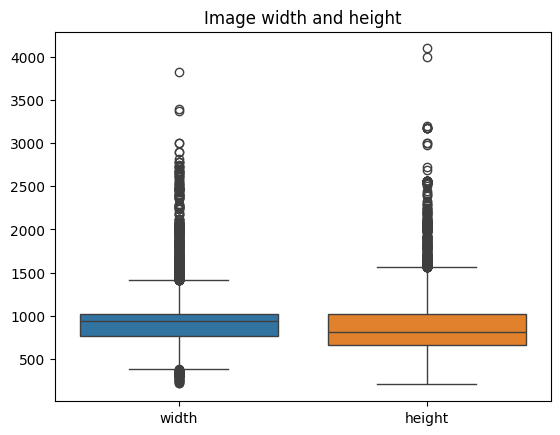

In [21]:
img_size = np.zeros((total_df.shape[0],2))
for i, filename in enumerate(total_df['filename']) :
    img = img_to_array( load_img("data/" + filename) )
    img_size[i,:] = img.shape[:2]

# --- #

plt.figure()
ax = sns.boxplot(img_size)
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(['width', 'height'])
plt.title("Image width and height")
plt.show()

## Pretraitement

In [22]:
# On veux diviser dataset en 60%, 20%, 20% 
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(total_df, test_size=0.2, random_state=42)  # 80% train, 20% test
train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=42)  #val_df compte 25% de 80% cad 20% de dataset 



In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


batch_size = 20  # d
img_width = 150
img_height = 150

# Training images
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_dataframe(
    train_df,
     "data/",
    x_col = 'filename',
    y_col = 'category',
    target_size = (img_width, img_height),
    class_mode = 'categorical',
    batch_size = batch_size
)

val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_dataframe(
    val_df,
     "data/",
    x_col = 'filename',
    y_col = 'category',
    target_size = (img_width, img_height),
    class_mode = 'categorical',
    batch_size = batch_size
)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    test_df,
     "data/",
    x_col = 'filename',
    y_col = 'category',
    target_size = (img_width, img_height),
    class_mode = 'categorical',
    batch_size = batch_size
)


Found 5067 validated image filenames belonging to 50 classes.
Found 1689 validated image filenames belonging to 50 classes.
Found 1690 validated image filenames belonging to 50 classes.


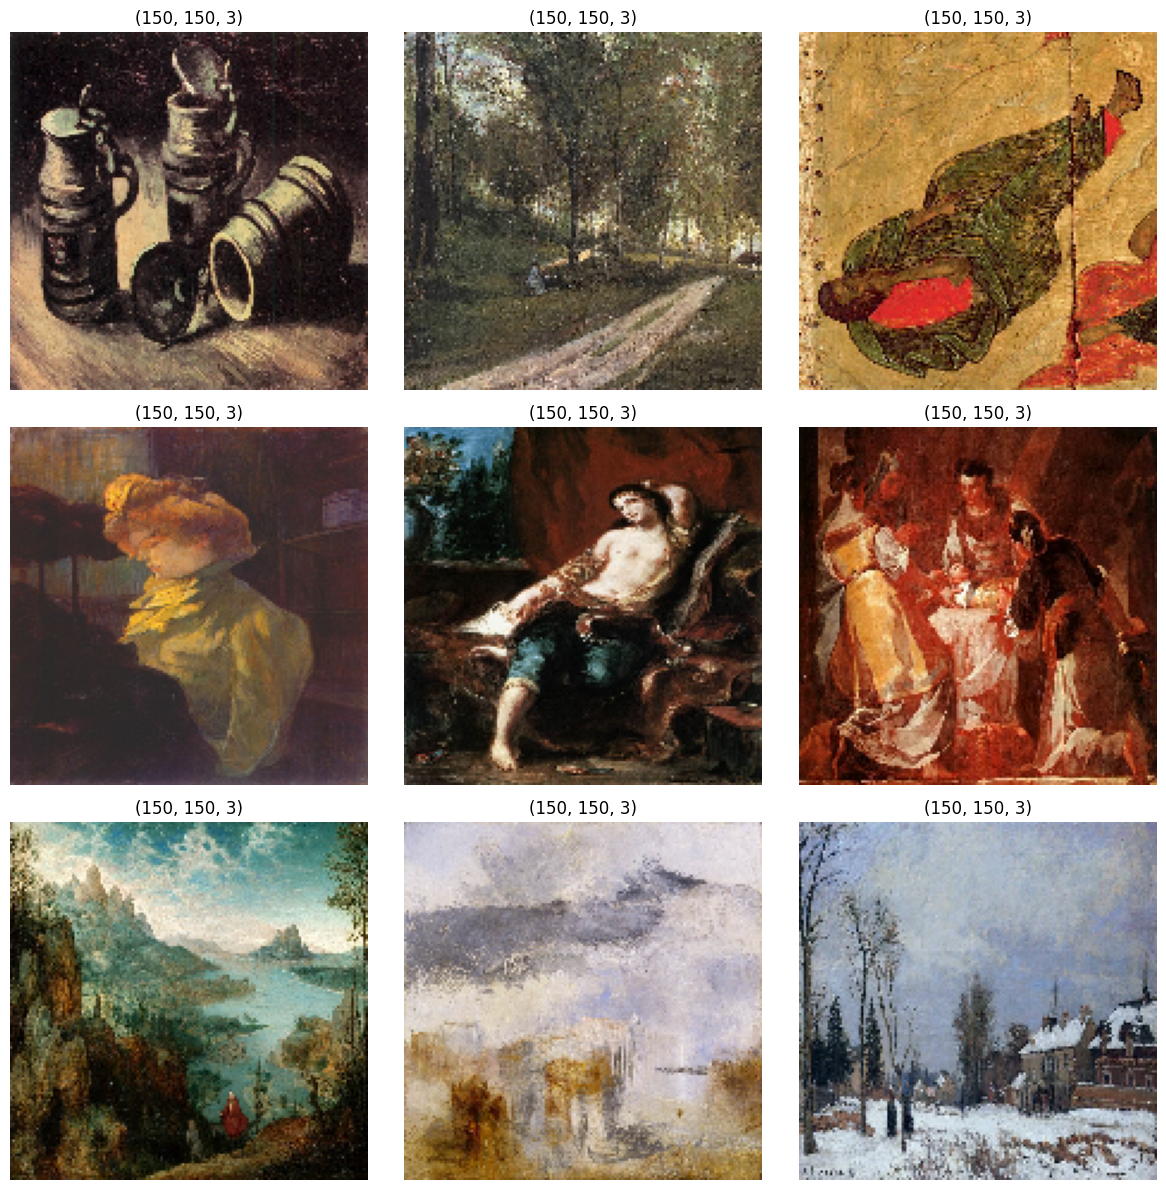

In [24]:
plt.figure(figsize=(12, 12))

for i in range(9):
    plt.subplot(3, 3, i+1)
    for x_batch, y_batch in train_generator:
        img = x_batch[0]
        
        plt.title(str(img.shape))
        plt.imshow(img)
        plt.axis('off')
        plt.grid(False)
        break

plt.tight_layout()
plt.show()

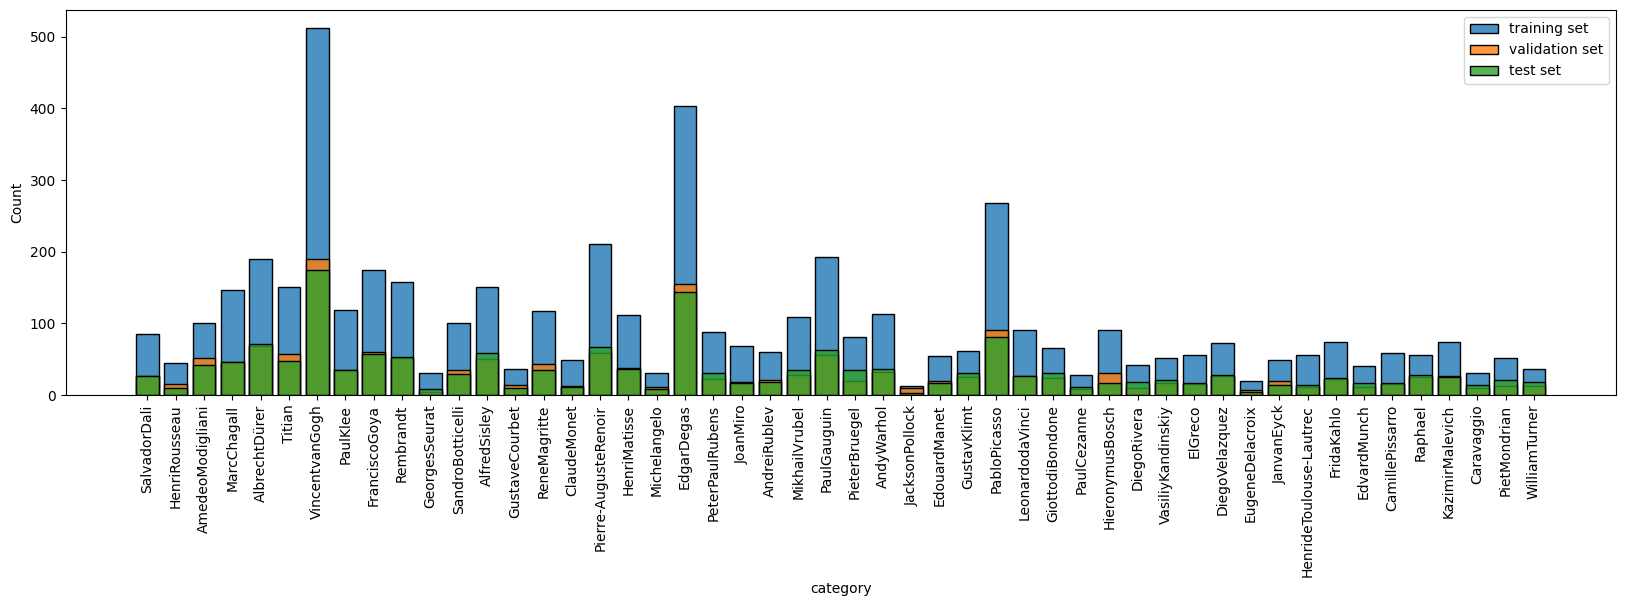

In [28]:
plt.figure(figsize=(20,5))

sns.histplot(train_df.iloc[:,1],label="training set",discrete=True, alpha=.8, shrink=.8)
sns.histplot(val_df.iloc[:,1],label="validation set",discrete=True, alpha=.8, shrink=.8)
sns.histplot(test_df.iloc[:,1],label="test set",discrete=True, alpha=.8, shrink=.8)
plt.xticks(rotation=90)



plt.xticks(rotation=90)

plt.legend()

## First approach: Basic convolutional network

In [30]:
cnn_simple = Sequential()
cnn_simple.add(Input(shape=(150,150, 3)))
cnn_simple.add(Conv2D(32, kernel_size=(3, 3), activation='relu', data_format="channels_last"))
cnn_simple.add(MaxPooling2D(pool_size=(2, 2)))
cnn_simple.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
cnn_simple.add(MaxPooling2D(pool_size=(2, 2)))
cnn_simple.add(Conv2D(96, kernel_size=(3, 3), activation='relu'))
cnn_simple.add(MaxPooling2D(pool_size=(2, 2)))
cnn_simple.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
cnn_simple.add(MaxPooling2D(pool_size=(2, 2)))
cnn_simple.add(Flatten())    # Vectorization of the tensor to connect it to a dense layer
cnn_simple.add(Dense(64, activation='relu'))
cnn_simple.add(Dropout(0.5))
cnn_simple.add(Dense(50, activation='softmax'))

cnn_simple.summary()

2024-10-17 14:44:05.169663: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10141 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:65:00.0, compute capability: 6.1


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 96)     │        55,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 128)    │       110,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       401,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         3,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 590,226 (2.25 MB)

 Trainable params: 590,226 (2.25 MB)

 Non-trainable params: 0 (0.00 B)

In [68]:
cnn_simple.compile(
    loss = 'categorical_crossentropy',
    optimizer = Adam(learning_rate=3e-3),
    metrics = ['accuracy'])

In [69]:
epochs = 10

t_learning_cnn_simple = time.time()
cnn_simple_history = cnn_simple.fit(
    train_generator,
    validation_data = val_generator,
    epochs = epochs
)
t_learning_cnn_simple = time.time() - t_learning_cnn_simple

print("Learning time for %d epochs : %d seconds" % (epochs, t_learning_cnn_simple))

Epoch 1/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 57s 203ms/step - accuracy: 0.0940 - loss: 3.6411 - val_accuracy: 0.1125 - val_loss: 3.5847
Epoch 2/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 49s 188ms/step - accuracy: 0.1007 - loss: 3.6180 - val_accuracy: 0.1125 - val_loss: 3.5824
Epoch 3/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 51s 196ms/step - accuracy: 0.1047 - loss: 3.6135 - val_accuracy: 0.1125 - val_loss: 3.5814
Epoch 4/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 50s 192ms/step - accuracy: 0.0999 - loss: 3.6239 - val_accuracy: 0.1125 - val_loss: 3.5807
Epoch 5/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 50s 193ms/step - accuracy: 0.0974 - loss: 3.6323 - val_accuracy: 0.1125 - val_loss: 3.5808
Epoch 6/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 49s 189ms/step - accuracy: 0.0982 - loss: 3.6252 - val_accuracy: 0.1125 - val_loss: 3.5803
Epoch 7/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 50s 194ms/step - accuracy: 0.1061 - loss: 3.6122 - val_accuracy: 0.1125 - val_loss: 3.5807
Epoch 8/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 49s 190ms/step - accuracy: 0.1084 - loss: 3

In [70]:
t_prediction_cnn_simple = time.time()

score_cnn_train = cnn_simple.evaluate(train_generator, verbose=1)
score_cnn_validation = cnn_simple.evaluate(val_generator, verbose=1)

t_prediction_cnn_simple = time.time() - t_prediction_cnn_simple

print('Train accuracy:', score_cnn_train[1])
print('Validation accuracy:', score_cnn_validation[1])
print("Time Prediction: %.2f seconds" % t_prediction_cnn_simple )

254/254 ━━━━━━━━━━━━━━━━━━━━ 36s 143ms/step - accuracy: 0.0955 - loss: 3.6381
85/85 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - accuracy: 0.1257 - loss: 3.5417
Train accuracy: 0.10104598104953766
Validation accuracy: 0.11249259859323502
Time Prediction: 49.51 seconds


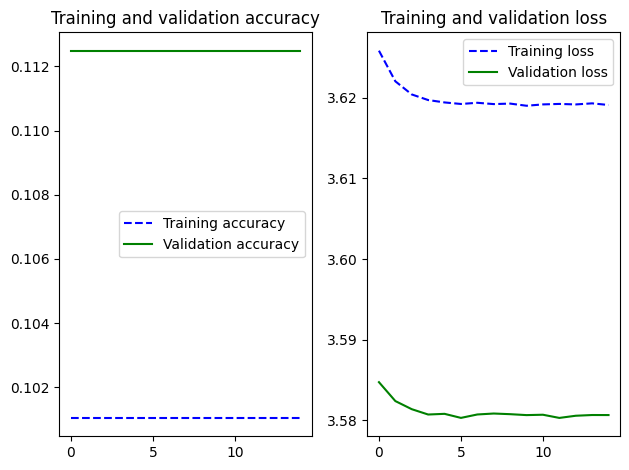

In [71]:
# %load solutions/CatsDogs/plot_training_analysis.py
def plot_training_analysis(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.subplot(1,2,1)
    plt.plot(epochs, acc, 'b', linestyle="--",label='Training accuracy')
    plt.plot(epochs, val_acc, 'g', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, loss, 'b', linestyle="--",label='Training loss')
    plt.plot(epochs, val_loss,'g', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_analysis(cnn_simple_history)

In [72]:
# Obtenez les prédictions du modèle sur l'ensemble de test
predictions = cnn_simple.predict(test_generator)

# Convertissez les prédictions en labels (en prenant l'index avec la plus haute probabilité)
predicted_classes = np.argmax(predictions, axis=1)

# Obtenez les vraies étiquettes à partir du générateur
true_classes = test_generator.classes

# Obtenez les noms de classes (catégories/étiquettes)
class_labels = list(test_generator.class_indices.keys())

85/85 ━━━━━━━━━━━━━━━━━━━━ 13s 149ms/step


In [62]:
from sklearn.metrics import accuracy_score, classification_report

# Créez un rapport de classification avec précision, rappel et F1-score pour chaque catégorie
report = classification_report(true_classes, predicted_classes, target_names=class_labels, output_dict=True)

# Convertir le rapport de classification en DataFrame pour faciliter la manipulation
report_df = pd.DataFrame(report).transpose()

# Extraire seulement la colonne 'precision' et trier par ordre décroissant
sorted_accuracy = report_df[['f1-score']].sort_values(by='f1-score', ascending=False)

# Afficher le résultat
print(sorted_accuracy)

                         f1-score
VincentvanGogh           0.174098
EdgarDegas               0.146535
PaulGauguin              0.084034
Rembrandt                0.068376
FranciscoGoya            0.065217
accuracy                 0.064497
MikhailVrubel            0.054054
weighted avg             0.048016
AlbrechtDürer            0.046784
Pierre-AugusteRenoir     0.043011
AlfredSisley             0.040816
PeterPaulRubens          0.037736
SandroBotticelli         0.031746
ReneMagritte             0.024390
PabloPicasso             0.024242
AndyWarhol               0.022472
Titian                   0.021053
macro avg                0.017691
AndreiRublev             0.000000
ClaudeMonet              0.000000
AmedeoModigliani         0.000000
GustaveCourbet           0.000000
GustavKlimt              0.000000
GiottodiBondone          0.000000
GeorgesSeurat            0.000000
FridaKahlo               0.000000
EugeneDelacroix          0.000000
ElGreco                  0.000000
EdvardMunch   

/home/jsouffle/.conda/envs/tensorflow/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jsouffle/.conda/envs/tensorflow/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jsouffle/.conda/envs/tensorflow/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

In [61]:
test_df.iloc[:, 1].value_counts(ascending=False)

category
VincentvanGogh             175
EdgarDegas                 143
PabloPicasso                81
AlbrechtDürer               71
Pierre-AugusteRenoir        67
PaulGauguin                 63
AlfredSisley                58
FranciscoGoya               57
Rembrandt                   53
Titian                      47
MarcChagall                 46
AmedeoModigliani            41
HenriMatisse                36
AndyWarhol                  36
MikhailVrubel               34
ReneMagritte                34
PieterBruegel               34
PaulKlee                    34
PeterPaulRubens             31
GustavKlimt                 31
GiottodiBondone             30
SandroBotticelli            29
Raphael                     28
DiegoVelazquez              28
LeonardodaVinci             27
SalvadorDali                27
KazimirMalevich             25
FridaKahlo                  24
VasiliyKandinskiy           21
PietMondrian                21
AndreiRublev                18
DiegoRivera                 18

In [ ]:
total_df = pd.DataFrame({
    'filename': train_filename,
    'category': labels
})

In [65]:
sorted_data

category
VincentvanGogh             877
EdgarDegas                 702
PabloPicasso               439
Pierre-AugusteRenoir       336
AlbrechtDürer              328
PaulGauguin                311
FranciscoGoya              291
Rembrandt                  262
AlfredSisley               259
Titian                     255
MarcChagall                239
ReneMagritte               194
AmedeoModigliani           193
PaulKlee                   188
HenriMatisse               186
AndyWarhol                 181
MikhailVrubel              171
SandroBotticelli           164
LeonardodaVinci            143
PeterPaulRubens            141
SalvadorDali               139
HieronymusBosch            137
PieterBruegel              134
DiegoVelazquez             128
KazimirMalevich            126
FridaKahlo                 120
GiottodiBondone            119
GustavKlimt                117
Raphael                    109
JoanMiro                   102
AndreiRublev                99
CamillePissarro             91

In [ ]:
# Compter le nombre d'éléments dans chaque catégorie
category_counts = total_df['category'].value_counts()

# Créer un générateur d'images avec augmentation de données
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Dossier temporaire pour stocker les images augmentées
os.makedirs('augmented_data', exist_ok=True)

# Liste pour stocker les DataFrames modifiés
balanced_dataframes = []

# Parcourir chaque catégorie
for category, count in category_counts.items():
    category_df = total_df[total_df['category'] == category]
    
    if count > 400:
        # Si la catégorie a plus de 400 éléments, échantillonner aléatoirement 400
        balanced_category_df = category_df.sample(n=400, random_state=42)
        balanced_dataframes.append(balanced_category_df)
    
    elif count < 400:
        # Si la catégorie a moins de 400 éléments, utiliser data augmentation pour atteindre 400
        balanced_category_df = category_df.copy()
        num_to_augment = 400 - count
        
        # Appliquer la data augmentation
        for index, row in category_df.iterrows():
            img_path = os.path.join('data', row['filename'])  # Chemin de l'image originale
            img = load_img(img_path)  # Charger l'image
            x = img_to_array(img)  # Convertir l'image en tableau numpy
            x = x.reshape((1,) + x.shape)  # Redimensionner pour le générateur
            
            # Générer des nouvelles images jusqu'à atteindre le nombre requis
            i = 0
            for batch in datagen.flow(x, batch_size=1, save_to_dir='augmented_data', save_prefix=row['category'], save_format='jpeg'):
                i += 1
                if i >= num_to_augment:
                    break
        
        # Ajouter les nouvelles images générées au DataFrame
        augmented_filenames = [f for f in os.listdir('augmented_data') if f.startswith(category)]
        augmented_data = pd.DataFrame({
            'filename': augmented_filenames,
            'category': [category] * len(augmented_filenames)
        })
        
        # Ajouter les données augmentées
        balanced_category_df = pd.concat([balanced_category_df, augmented_data], ignore_index=True)
        balanced_dataframes.append(balanced_category_df)
    
    else:
        # Si la catégorie a exactement 400 éléments, la conserver telle quelle
        balanced_dataframes.append(category_df)

# Combiner tous les DataFrames équilibrés
equilibre_df = pd.concat(balanced_dataframes, ignore_index=True)

# Vérifier le nombre d'images par catégorie pour s'assurer que tout est bien équilibré
print(equilibre_df['category'].value_counts())

In [ ]:
# On veux diviser dataset en 60%, 20%, 20% 
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(equilibre_df, test_size=0.2, random_state=42)  # 80% train, 20% test
train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=42)  #val_df compte 25% de 80% cad 20% de dataset 



In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


batch_size = 20  # d
img_width = 150
img_height = 150

# Training images
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_dataframe(
    train_df,
     "data/",
    x_col = 'filename',
    y_col = 'category',
    target_size = (img_width, img_height),
    class_mode = 'categorical',
    batch_size = batch_size
)

val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_dataframe(
    val_df,
     "data/",
    x_col = 'filename',
    y_col = 'category',
    target_size = (img_width, img_height),
    class_mode = 'categorical',
    batch_size = batch_size
)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    test_df,
     "data/",
    x_col = 'filename',
    y_col = 'category',
    target_size = (img_width, img_height),
    class_mode = 'categorical',
    batch_size = batch_size
)


Found 5067 validated image filenames belonging to 50 classes.
Found 1689 validated image filenames belonging to 50 classes.
Found 1690 validated image filenames belonging to 50 classes.


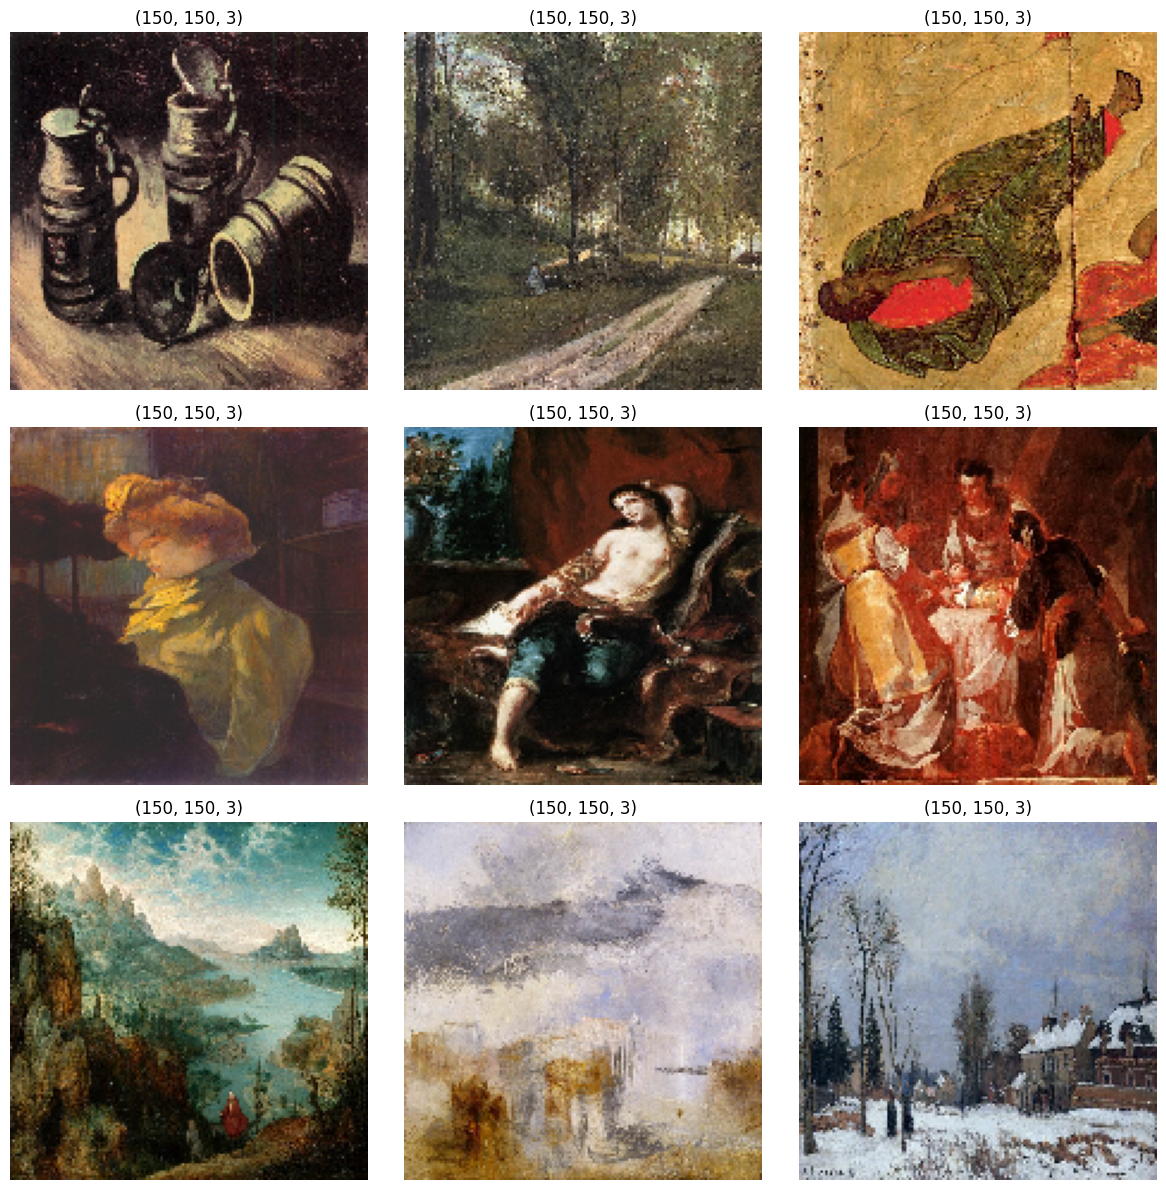

In [24]:
plt.figure(figsize=(12, 12))

for i in range(9):
    plt.subplot(3, 3, i+1)
    for x_batch, y_batch in train_generator:
        img = x_batch[0]
        
        plt.title(str(img.shape))
        plt.imshow(img)
        plt.axis('off')
        plt.grid(False)
        break

plt.tight_layout()
plt.show()

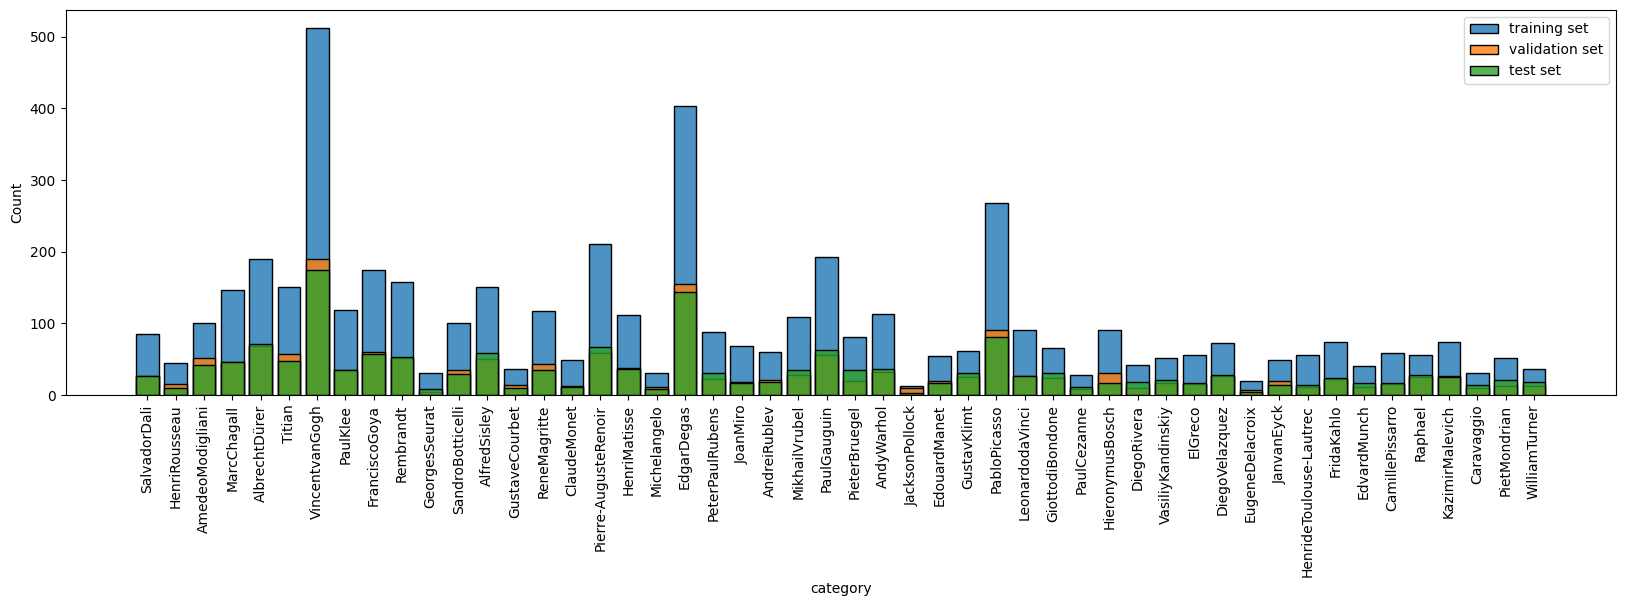

In [28]:
plt.figure(figsize=(20,5))

sns.histplot(train_df.iloc[:,1],label="training set",discrete=True, alpha=.8, shrink=.8)
sns.histplot(val_df.iloc[:,1],label="validation set",discrete=True, alpha=.8, shrink=.8)
sns.histplot(test_df.iloc[:,1],label="test set",discrete=True, alpha=.8, shrink=.8)
plt.xticks(rotation=90)



plt.xticks(rotation=90)

plt.legend()

In [30]:
cnn_equilibre = Sequential()
cnn_equilibre.add(Input(shape=(150,150, 3)))
cnn_equilibre.add(Conv2D(32, kernel_size=(3, 3), activation='relu', data_format="channels_last"))
cnn_equilibre.add(MaxPooling2D(pool_size=(2, 2)))
cnn_equilibre.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
cnn_equilibre.add(MaxPooling2D(pool_size=(2, 2)))
cnn_equilibre.add(Conv2D(96, kernel_size=(3, 3), activation='relu'))
cnn_equilibre.add(MaxPooling2D(pool_size=(2, 2)))
cnn_equilibre.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
cnn_equilibre.add(MaxPooling2D(pool_size=(2, 2)))
cnn_equilibre.add(Flatten())    # Vectorization of the tensor to connect it to a dense layer
cnn_equilibre.add(Dense(64, activation='relu'))
cnn_equilibre.add(Dropout(0.5))
cnn_equilibre.add(Dense(50, activation='softmax'))

cnn_equilibre.summary()

2024-10-17 14:44:05.169663: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10141 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:65:00.0, compute capability: 6.1


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 96)     │        55,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 128)    │       110,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       401,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         3,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 590,226 (2.25 MB)

 Trainable params: 590,226 (2.25 MB)

 Non-trainable params: 0 (0.00 B)

In [68]:
cnn_equilibre.compile(
    loss = 'categorical_crossentropy',
    optimizer = Adam(learning_rate=3e-3),
    metrics = ['accuracy'])

In [ ]:
epochs = 15

t_learning_cnn_equilibre = time.time()
cnn_equilibre = cnn_equilibre.fit(
    train_generator,
    validation_data = val_generator,
    epochs = epochs
)
t_learning_cnn_equilibre = time.time() - t_learning_cnn_equilibre

print("Learning time for %d epochs : %d seconds" % (epochs, t_learning_cnn_equilibre))

Epoch 1/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 57s 203ms/step - accuracy: 0.0940 - loss: 3.6411 - val_accuracy: 0.1125 - val_loss: 3.5847
Epoch 2/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 49s 188ms/step - accuracy: 0.1007 - loss: 3.6180 - val_accuracy: 0.1125 - val_loss: 3.5824
Epoch 3/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 51s 196ms/step - accuracy: 0.1047 - loss: 3.6135 - val_accuracy: 0.1125 - val_loss: 3.5814
Epoch 4/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 50s 192ms/step - accuracy: 0.0999 - loss: 3.6239 - val_accuracy: 0.1125 - val_loss: 3.5807
Epoch 5/15
131/254 ━━━━━━━━━━━━━━━━━━━━ 17s 141ms/step - accuracy: 0.0936 - loss: 3.6462

In [ ]:
t_prediction_cnn_equilibre = time.time()

score_cnn_train = cnn_equilibre.evaluate(train_generator, verbose=1)
score_cnn_validation = cnn_equilibre.evaluate(val_generator, verbose=1)

t_prediction_cnn_equilibre = time.time() - t_prediction_cnn_equilibre

print('Train accuracy:', score_cnn_train[1])
print('Validation accuracy:', score_cnn_validation[1])
print("Time Prediction: %.2f seconds" % t_prediction_cnn_simple )

In [ ]:
# %load solutions/CatsDogs/plot_training_analysis.py
def plot_training_analysis(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.subplot(1,2,1)
    plt.plot(epochs, acc, 'b', linestyle="--",label='Training accuracy')
    plt.plot(epochs, val_acc, 'g', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, loss, 'b', linestyle="--",label='Training loss')
    plt.plot(epochs, val_loss,'g', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_analysis(cnn_simple_history)

In [ ]:
# Obtenez les prédictions du modèle sur l'ensemble de test
predictions = cnn_equilibre.predict(test_generator)

# Convertissez les prédictions en labels (en prenant l'index avec la plus haute probabilité)
predicted_classes = np.argmax(predictions, axis=1)

# Obtenez les vraies étiquettes à partir du générateur
true_classes = test_generator.classes

# Obtenez les noms de classes (catégories/étiquettes)
class_labels = list(test_generator.class_indices.keys())

In [62]:
from sklearn.metrics import accuracy_score, classification_report

# Créez un rapport de classification avec précision, rappel et F1-score pour chaque catégorie
report = classification_report(true_classes, predicted_classes, target_names=class_labels, output_dict=True)

# Convertir le rapport de classification en DataFrame pour faciliter la manipulation
report_df = pd.DataFrame(report).transpose()

# Extraire seulement la colonne 'precision' et trier par ordre décroissant
sorted_accuracy = report_df[['f1-score']].sort_values(by='f1-score', ascending=False)

# Afficher le résultat
print(sorted_accuracy)

                         f1-score
VincentvanGogh           0.174098
EdgarDegas               0.146535
PaulGauguin              0.084034
Rembrandt                0.068376
FranciscoGoya            0.065217
accuracy                 0.064497
MikhailVrubel            0.054054
weighted avg             0.048016
AlbrechtDürer            0.046784
Pierre-AugusteRenoir     0.043011
AlfredSisley             0.040816
PeterPaulRubens          0.037736
SandroBotticelli         0.031746
ReneMagritte             0.024390
PabloPicasso             0.024242
AndyWarhol               0.022472
Titian                   0.021053
macro avg                0.017691
AndreiRublev             0.000000
ClaudeMonet              0.000000
AmedeoModigliani         0.000000
GustaveCourbet           0.000000
GustavKlimt              0.000000
GiottodiBondone          0.000000
GeorgesSeurat            0.000000
FridaKahlo               0.000000
EugeneDelacroix          0.000000
ElGreco                  0.000000
EdvardMunch   

/home/jsouffle/.conda/envs/tensorflow/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jsouffle/.conda/envs/tensorflow/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jsouffle/.conda/envs/tensorflow/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.